# Analyse and Visualize Model 

In [11]:
# Imports

from argparse import ArgumentParser, RawTextHelpFormatter
import torch
from torch.utils.data import DataLoader
import numpy as np
import os
import json
import cv2 as cv
import open3d as o3d 
from gradslam.structures.rgbdimages import RGBDImages
from end2endslam.dataloader.tum import TUM
from end2endslam.dataloader.nyu import NYU
from gradslam.slam.pointfusion import PointFusion
from gradslam.structures.pointclouds import Pointclouds
from end2endslam.scsfmwrapper import SCSfmWrapper
from losses.unified_loss import pred_loss_unified
from losses.gt_loss import compute_errors 
from torch.optim import Adam
from torch.utils.tensorboard import SummaryWriter
import matplotlib as mpl
import matplotlib.cm as cm
import imageio
from end2endslam.pointfusion_scsfm_utils import compute_scaling_coef, slam_step
import matplotlib.pyplot as plt
from end2endslam.losses.loss_utils.inverse_warp import inverse_warp2
from end2endslam.losses.loss_utils.scsfm_loss import compute_ssim_loss, mean_on_mask
import csv
import pandas as pd

## Training Parameters

In [2]:
# File paths 
model_directory_path = "../debug_folder/xyz_previous_001"

In [3]:
# get args
class Bunch(object): # in order to call args.seed 
    def __init__(self, adict):
        self.__dict__.update(adict)
        
args_file_path = os.path.join(model_directory_path, 'args.txt')
with open(args_file_path) as f:
    args = json.load(f)
    args = Bunch(args)
print(args.__dict__)

{'dataset': 'tum', 'dataset_path': '../sample_data/dataset_TUM_freiburg2xyz', 'odometry': 'gt', 'sequences': 'rgbd_dataset_freiburg2_xyz', 'debug_path': '../debug_folder', 'model_name': 'xyz_previous_001', 'seq_length': 10, 'seq_dilation': 100, 'seq_stride': None, 'seq_start': None, 'seq_end': None, 'batch_size': 5, 'max_num_batches': 2, 'num_epochs': 200, 'log_freq': 30, 'projection_mode': 'previous', 'loss_photo_factor': 1.0, 'loss_geom_factor': 0.5, 'loss_smooth_factor': 0.1, 'loss_cons_factor': 0.0, 'loss_gt_factor': 0.0, 'seed': 123, 'max_scale': 1, 'learning_rate': 1e-06}


## Plotting Losses

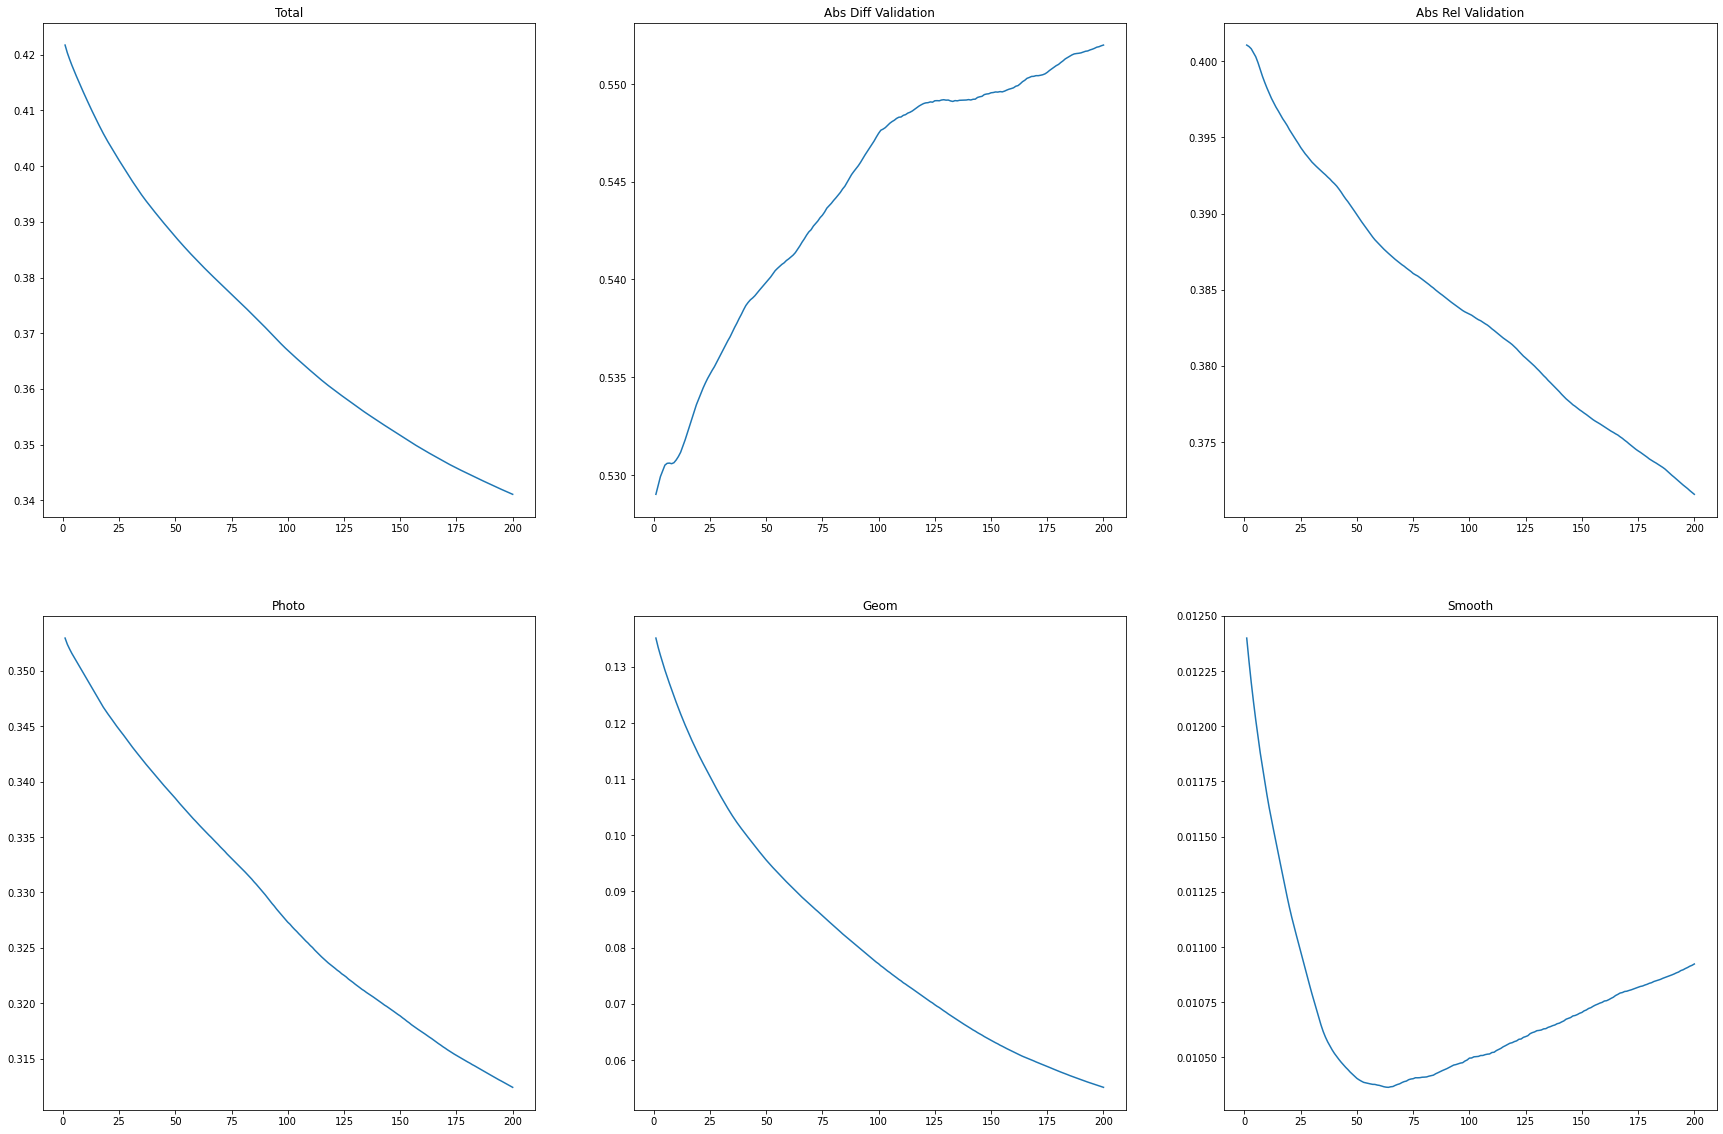

In [28]:
summary_path = os.path.join(model_directory_path, "training_summary.csv")
data = pd.read_csv(summary_path)

iteration = data["iteration"].values
com = data["com"].values
photo = data["photo"].values
geom = data["geom"].values
smooth = data["smooth"].values
val_abs_diff = data["val_abs_diff"].values
val_abs_rel = data["val_abs_rel"].values

plt.figure(figsize=(30,20))
ax = plt.subplot(2,3,1)
ax.set_title("Total")
ax.plot(iteration, com)
ax = plt.subplot(2,3,2)
ax.set_title("Abs Diff Validation")
ax.plot(iteration, val_abs_diff)
ax = plt.subplot(2,3,3)
ax.set_title("Abs Rel Validation")
ax.plot(iteration, val_abs_rel)
ax = plt.subplot(2,3,4)
ax.set_title("Photo")
ax.plot(iteration, photo)
ax = plt.subplot(2,3,5)
ax.set_title("Geom")
ax.plot(iteration, geom)
ax = plt.subplot(2,3,6)
ax.set_title("Smooth")
ax.plot(iteration, smooth)


## Preparation:

In [4]:
# Use this to modify args
args.seed = 111

In [5]:
torch.manual_seed(args.seed)
np.random.seed(args.seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.cuda.manual_seed(args.seed)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

#original image size (hardcoded for TUM!)
ORIG_HEIGHT = 480
ORIG_WIDTH = 640

#image size used for depth prediction
DEPTH_PRED_HEIGHT = 256 #256
DEPTH_PRED_WIDTH = 320 #320

#image size used for SLAM
SLAM_HEIGHT = 64#128
SLAM_WIDTH = 80#160

#DEPTH PREDICTION MODEL PARAMETERS
RESNET_LAYERS = 18

## Load Networks

In [6]:
# Initialize DepthPrediction Network 1
model_weights_file = "untrained" # put "untrained" for original weights
if model_weights_file == "untrained":
    model_weights_path = os.path.join(os.path.abspath(''), "models/r18_rectified_nyu/dispnet_model_best.pth.tar")
else:
    model_weights_path = os.path.join(model_directory_path, model_weights_file)

depth_net_1 = SCSfmWrapper(
    device=device,
    pretrained=True,
    pretrained_path=model_weights_path,
    resnet_layers = RESNET_LAYERS)

-> Loading model from  /home/matthias/git/End-2-end-self-supervised-SLAM/end2endslam/models/r18_rectified_nyu/dispnet_model_best.pth.tar


In [8]:
# Initialize DepthPrediction Network 2
model_weights_file = "model_epoch_180" # put "untrained" for original weights
if model_weights_file == "untrained":
    model_weights_path = os.path.join(os.path.abspath(''), "models/r18_rectified_nyu/dispnet_model_best.pth.tar")
else:
    model_weights_path = os.path.join(model_directory_path, model_weights_file)

depth_net_2 = SCSfmWrapper(
    device=device,
    pretrained=True,
    pretrained_path=model_weights_path,
    resnet_layers = RESNET_LAYERS)

-> Loading model from  ../debug_folder/xyz_previous_001/model_epoch_180


## Load Data

In [8]:
# Load Dataset
if args.dataset == "tum":
    #need to have images in 320x256 size as input to sc-sfml net. Thus first we rescale by 1.875, then crop horizontally
    height = DEPTH_PRED_HEIGHT#256 #640/2
    width = int(np.ceil(ORIG_WIDTH*(DEPTH_PRED_HEIGHT/ORIG_HEIGHT))) #342 #ceil(480/2)
    cropped_width = DEPTH_PRED_WIDTH #320 #crop hotizontally (equal margin at both sides)
    dataset = TUM(args.dataset_path, seqlen=args.seq_length, height=height, width=width, cropped_width=cropped_width, sequences=args.sequences,
                  dilation=args.seq_dilation,stride = args.seq_stride,start = args.seq_start, end = args.seq_end)
elif args.dataset == "nyu":
    # right now only working with rectified pictures as provided by SfM-github
    dataset = NYU(args.dataset_path, version="rectified", seqlen=args.seq_length, height=DEPTH_PRED_HEIGHT, width=DEPTH_PRED_WIDTH, sequences=None)

In [9]:
# get data
args.batch_size = 1
loader = DataLoader(dataset=dataset, batch_size=args.batch_size, shuffle=False )

## Sequence Preprocessing

In [10]:
# Get data
(colors, depths, intrinsics, *rest) = next(iter(loader)) 
batch_id = 0
batch_idx = 0
e_idx = 0
frame_id = 0

In [11]:
colors = colors.to(device)
depths = depths.to(device)
intrinsics = intrinsics.to(device)

# TODO: make NYU data loader return dummy gt poses
if args.dataset == 'tum':
    gt_poses = rest[0].to(device)
else:
    gt_poses = torch.eye(4, device=device).view(1, 4, 4).repeat(args.batch_size, args.seq_length, 1, 1)

# Hard coded
pred_depths = []

# Scale intrinsics since SLAM works on downsampled images
intrinsics_slam = intrinsics.clone().detach()
intrinsics_slam[:, :, 0, :] = intrinsics_slam[:, :, 0, :] * SLAM_WIDTH / DEPTH_PRED_WIDTH
intrinsics_slam[:, :, 1, :] = intrinsics_slam[:, :, 1, :] * SLAM_HEIGHT / DEPTH_PRED_HEIGHT
# Intrinsics are already scaled in TUM dataloader!
intrinsics_depth = intrinsics.clone().detach()

## Depth Rescaling

In [12]:
# Load initial frame: 
pred_index = 0
if pred_index >= args.seq_length:
    print("pred_index out of bounds")
# get input tensors
input_dict = {"device": device}
input_dict["rgb"] = (colors[:, pred_index, ::] / 255.0).permute(0, 3, 1, 2)
input_dict["rgb_ref"] = (colors[:, pred_index - 1, ::] / 255.0).permute(0, 3, 1, 2)

input_dict["depth"] = depths[:, pred_index, ::].permute(0, 3, 1, 2)
input_dict["depth_ref"] = depths[:, pred_index - 1, ::].permute(0, 3, 1, 2)
input_dict["gt_poses"] = gt_poses[:, pred_index, ::]
input_dict["intrinsic_slam"] = intrinsics_slam
input_dict["intrinsic_depth"] = intrinsics_depth

In [13]:
# Scale depth for network 1
depth_predictions = depth_net_1(input_dict["rgb"])
input_dict["pred_depths"] = depth_predictions
scale_coeff, vmin_vis, vmax_vis = compute_scaling_coef(args, input_dict)
depth_net_1.scale_coeff = scale_coeff

Scaling coefficient: 3.5030875205993652
Mean (gt, pred): 1.3529491424560547, 0.3468959629535675
Median (gt, pred): 1.1318000555038452, 0.3230864405632019
Min (gt, pred): 0.7896000146865845, 0.24497078359127045
Max (gt, pred): 5.278800010681152, 0.5753733515739441
Std (gt, pred): 0.7827855944633484, 0.07806144654750824


In [14]:
# Scale depth for network 2
depth_predictions = depth_net_2(input_dict["rgb"])
input_dict["pred_depths"] = depth_predictions
scale_coeff, vmin_vis, vmax_vis = compute_scaling_coef(args, input_dict)
depth_net_2.scale_coeff = scale_coeff

Scaling coefficient: 3.5819647312164307
Mean (gt, pred): 1.3529491424560547, 0.35021865367889404
Median (gt, pred): 1.1318000555038452, 0.31597185134887695
Min (gt, pred): 0.7896000146865845, 0.2586597204208374
Max (gt, pred): 5.278800010681152, 0.5798464417457581
Std (gt, pred): 0.7827855944633484, 0.07955065369606018


# Pairwise Analysis

In [15]:
pred_index = 1

In [16]:
if pred_index >= args.seq_length or pred_index < 1:
    print("pred_index out of bounds")
# get input tensors
input_dict = {"device": device}
input_dict["rgb"] = (colors[:, pred_index, ::] / 255.0).permute(0, 3, 1, 2)
input_dict["rgb_ref"] = (colors[:, pred_index - 1, ::] / 255.0).permute(0, 3, 1, 2)
input_dict["depth"] = depths[:, pred_index, ::].permute(0, 3, 1, 2)
input_dict["depth_ref"] = depths[:, pred_index - 1, ::].permute(0, 3, 1, 2)
input_dict["gt_poses"] = gt_poses[:, pred_index, ::]
input_dict["gt_poses_ref"] = gt_poses[:, pred_index - 1, ::]
input_dict["intrinsic_slam"] = intrinsics_slam
input_dict["intrinsic_depth"] = intrinsics_depth

In [17]:
# predict depth with network 1
input_dict["pred_depths_ref_1"] = depth_net_1(input_dict["rgb_ref"])
input_dict["pred_depths_1"] = depth_net_1(input_dict["rgb"])

In [18]:
# predict depth with network 2
input_dict["pred_depths_ref_2"] = depth_net_2(input_dict["rgb_ref"])
input_dict["pred_depths_2"] = depth_net_2(input_dict["rgb"])

## Depth Visualization

Validation errors: ['abs_diff', 'abs_rel', 'sq_rel', 'a1', 'a2', 'a3']
pred1 (left): [0.4184403419494629, 0.2849181294441223, 0.4142540693283081, 0.7552076578140259, 0.8220893740653992, 0.8323001861572266]
pred2 (right): [0.37203019857406616, 0.24096818268299103, 0.35476577281951904, 0.813294529914856, 0.8287129998207092, 0.8388766646385193]


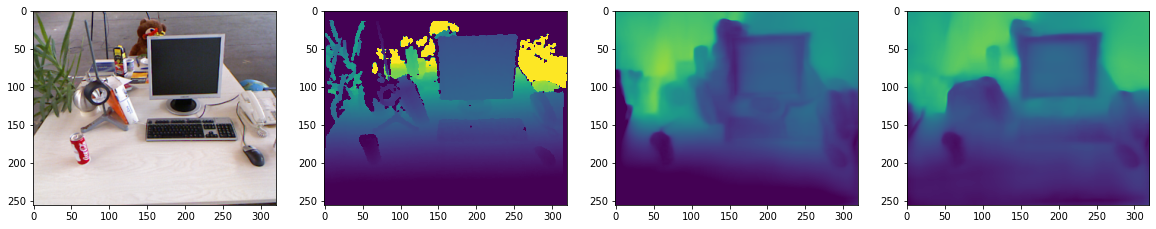

In [19]:
if args.batch_size == 1:
    plt.figure(figsize=(20,20))
    ax = plt.subplot(1,4,1)
    ax.imshow(input_dict["rgb"].detach().cpu().permute(0, 2, 3, 1).squeeze().numpy())
    ax = plt.subplot(1,4,2)
    ax.imshow(input_dict["depth"].detach().cpu().squeeze().cpu().numpy(), vmin=vmin_vis, vmax=vmax_vis)
    ax = plt.subplot(1,4,3)
    ax.imshow(input_dict["pred_depths_1"][0].detach().cpu().squeeze().cpu().numpy(), vmin=vmin_vis, vmax=vmax_vis)
    ax = plt.subplot(1,4,4)
    ax.imshow(input_dict["pred_depths_2"][0].detach().cpu().squeeze().cpu().numpy(), vmin=vmin_vis, vmax=vmax_vis)
else:
    plt.figure(figsize=(20,20))
    ax = plt.subplot(1,4,1)
    ax.imshow(np.vstack(input_dict["rgb"].detach().cpu().permute(0, 2, 3, 1).squeeze().numpy()))
    ax = plt.subplot(1,4,2)
    ax.imshow(np.vstack(input_dict["depth"].detach().cpu().squeeze().cpu().numpy(), vmin=vmin_vis, vmax=vmax_vis))
    ax = plt.subplot(1,4,3)
    ax.imshow(np.vstack(input_dict["pred_depths_1"][0].detach().cpu().squeeze().cpu().numpy(), vmin=vmin_vis, vmax=vmax_vis))
    ax = plt.subplot(1,4,4)
    ax.imshow(np.vstack(input_dict["pred_depths_2"][0].detach().cpu().squeeze().cpu().numpy(), vmin=vmin_vis, vmax=vmax_vis))

print("Validation errors: ['abs_diff', 'abs_rel', 'sq_rel', 'a1', 'a2', 'a3']")
gt = input_dict["depth"][:,0,:,:]
pred1 = input_dict["pred_depths_1"][0][:,0,:,:]
validation_errors_1 = compute_errors(pred1, gt, args.dataset)
print("pred1 (left):", validation_errors_1)
pred2 = input_dict["pred_depths_2"][0][:,0,:,:]
validation_errors_2 = compute_errors(pred2, gt, args.dataset)
print("pred2 (right):", validation_errors_2)

## SLAM

In [26]:
# SLAM 1

# Initialize SLAM and pointclouds
slam = PointFusion(odom=args.odometry, dsratio=4, device=device)
pointclouds = Pointclouds(device=device)
live_frame = None

# Ref

input_dict_ref = dict()
input_dict_ref["intrinsic_slam"] = input_dict["intrinsic_slam"]
input_dict_ref["gt_poses"] = input_dict["gt_poses_ref"]

colors_ref_slam = torch.nn.functional.interpolate(input=input_dict["rgb_ref"], size=(SLAM_HEIGHT, SLAM_WIDTH), mode="bicubic")
pred_depths_ref_slam = torch.nn.functional.interpolate(input=input_dict["pred_depths_ref_1"][0], size=(SLAM_HEIGHT, SLAM_WIDTH), mode="nearest")
input_dict_ref["rgb_slam"] = colors_ref_slam
input_dict_ref["pred_depths_slam"] = pred_depths_ref_slam

slam, pointclouds, live_frame, relative_poses = slam_step(input_dict_ref, slam, pointclouds, live_frame, device, args)

# Frame

colors_slam = torch.nn.functional.interpolate(input=input_dict["rgb"], size=(SLAM_HEIGHT, SLAM_WIDTH), mode="bicubic")
pred_depths_slam = torch.nn.functional.interpolate(input=input_dict["pred_depths_1"][0], size=(SLAM_HEIGHT, SLAM_WIDTH), mode="nearest")
input_dict["rgb_slam"] = colors_slam
input_dict["pred_depths_slam"] = pred_depths_slam

slam, pointclouds, live_frame, relative_poses = slam_step(input_dict, slam, pointclouds, live_frame, device, args)

input_dict["pose_1"] = relative_poses.detach()

o3d.visualization.draw_geometries([pointclouds.open3d(0)])

In [25]:
# SLAM 2

# Initialize SLAM and pointclouds
slam = PointFusion(odom=args.odometry, dsratio=4, device=device)
pointclouds = Pointclouds(device=device)
live_frame = None

# Ref

input_dict_ref = dict()
input_dict_ref["intrinsic_slam"] = input_dict["intrinsic_slam"]
input_dict_ref["gt_poses"] = input_dict["gt_poses_ref"]

colors_ref_slam = torch.nn.functional.interpolate(input=input_dict["rgb_ref"], size=(SLAM_HEIGHT, SLAM_WIDTH), mode="bicubic")
pred_depths_ref_slam = torch.nn.functional.interpolate(input=input_dict["pred_depths_ref_2"][0], size=(SLAM_HEIGHT, SLAM_WIDTH), mode="nearest")
input_dict_ref["rgb_slam"] = colors_ref_slam
input_dict_ref["pred_depths_slam"] = pred_depths_ref_slam

slam, pointclouds, live_frame, relative_poses = slam_step(input_dict_ref, slam, pointclouds, live_frame, device, args)

# Frame

colors_slam = torch.nn.functional.interpolate(input=input_dict["rgb"], size=(SLAM_HEIGHT, SLAM_WIDTH), mode="bicubic")
pred_depths_slam = torch.nn.functional.interpolate(input=input_dict["pred_depths_2"][0], size=(SLAM_HEIGHT, SLAM_WIDTH), mode="nearest")
input_dict["rgb_slam"] = colors_slam
input_dict["pred_depths_slam"] = pred_depths_slam

slam, pointclouds, live_frame, relative_poses = slam_step(input_dict, slam, pointclouds, live_frame, device, args)

input_dict["pose_2"] = relative_poses.detach()

o3d.visualization.draw_geometries([pointclouds.open3d(0)])

In [22]:
# SLAM GT

# Initialize SLAM and pointclouds
slam = PointFusion(odom=args.odometry, dsratio=4, device=device)
pointclouds = Pointclouds(device=device)
live_frame = None

# Ref

input_dict_ref = dict()
input_dict_ref["intrinsic_slam"] = input_dict["intrinsic_slam"]
input_dict_ref["gt_poses"] = input_dict["gt_poses_ref"]

colors_ref_slam = torch.nn.functional.interpolate(input=input_dict["rgb_ref"], size=(SLAM_HEIGHT, SLAM_WIDTH), mode="bicubic")
pred_depths_ref_slam = torch.nn.functional.interpolate(input=input_dict["depth_ref"], size=(SLAM_HEIGHT, SLAM_WIDTH), mode="nearest")
input_dict_ref["rgb_slam"] = colors_ref_slam
input_dict_ref["pred_depths_slam"] = pred_depths_ref_slam

slam, pointclouds, live_frame, relative_poses = slam_step(input_dict_ref, slam, pointclouds, live_frame, device, args)

# Frame

colors_slam = torch.nn.functional.interpolate(input=input_dict["rgb"], size=(SLAM_HEIGHT, SLAM_WIDTH), mode="bicubic")
pred_depths_slam = torch.nn.functional.interpolate(input=input_dict["depth"], size=(SLAM_HEIGHT, SLAM_WIDTH), mode="nearest")
input_dict["rgb_slam"] = colors_slam
input_dict["pred_depths_slam"] = pred_depths_slam

slam, pointclouds, live_frame, relative_poses = slam_step(input_dict, slam, pointclouds, live_frame, device, args)

o3d.visualization.draw_geometries([pointclouds.open3d(0)])

## Reprojection Visualization

Losses (photometric, geometric):
Left (pred 1): (0.19847016036510468, 0.028852524235844612)
Middle (pred 2): (0.17741583287715912, 0.023864828050136566)
Right (gt): (0.17144478857517242, 0.05569753050804138)


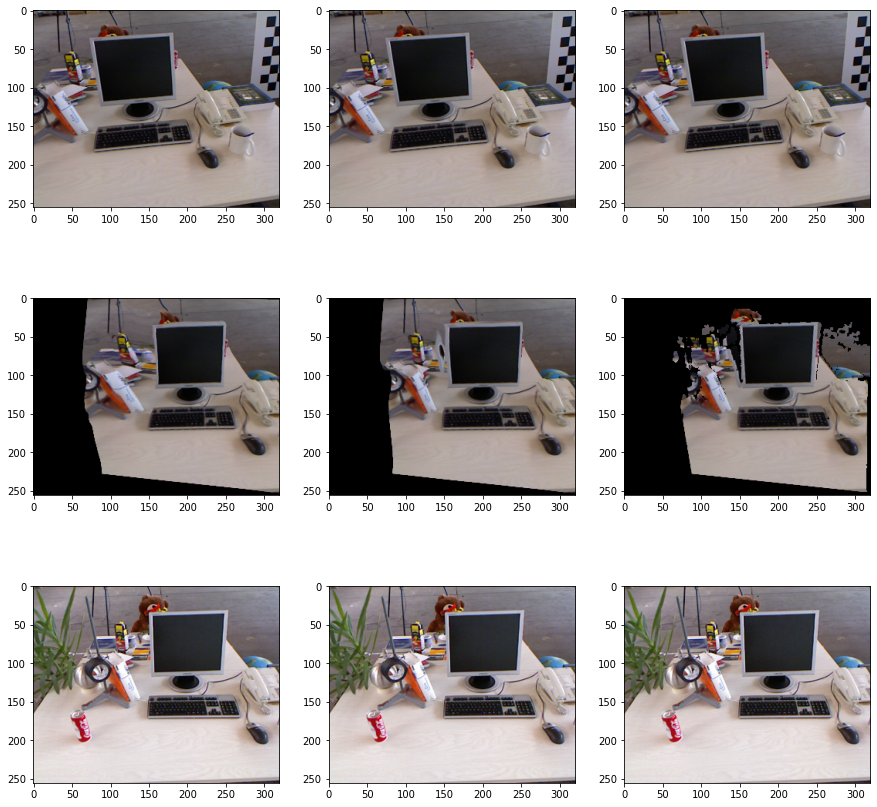

In [23]:
tgt_img = input_dict["rgb"]
ref_img = input_dict["rgb_ref"]
tgt_depth_1 = input_dict["pred_depths_1"][0]
ref_depth_1 = input_dict["pred_depths_ref_1"][0]
tgt_depth_2 = input_dict["pred_depths_2"][0]
ref_depth_2 = input_dict["pred_depths_ref_2"][0]
tgt_depth_gt = input_dict["depth"]
ref_depth_gt = input_dict["depth_ref"]
pose = input_dict["pose_1"][:,0,0:3,:]
with_ssim = 1
with_mask = 1
with_auto_mask = 0
padding_mode = 'zeros'
intrinsic = input_dict["intrinsic_depth"][:,0,0:3,0:3]
plt.figure(figsize = (15,15))

## Pred Depth 1

ref_img_warped, valid_mask, projected_depth, computed_depth = inverse_warp2(ref_img, tgt_depth_1, ref_depth_1, pose, intrinsic, padding_mode)

diff_img = (tgt_img - ref_img_warped).abs().clamp(0, 1)

diff_depth = ((computed_depth - projected_depth).abs() / (computed_depth + projected_depth)).clamp(0, 1)

if with_auto_mask == True:
    auto_mask = (diff_img.mean(dim=1, keepdim=True) < (tgt_img - ref_img).abs().mean(dim=1, keepdim=True)).float() * valid_mask
    valid_mask = auto_mask

if with_ssim == True:
    ssim_map = compute_ssim_loss(tgt_img, ref_img_warped)
    diff_img = (0.15 * diff_img + 0.85 * ssim_map)

if with_mask == True:
    weight_mask = (1 - diff_depth)
    diff_img = diff_img * weight_mask
    
# Original Color Vis
ax = plt.subplot(3,3,1)
vis_orig_color = ref_img.permute(0, 2, 3, 1).detach().squeeze().cpu().numpy()
ax.imshow(vis_orig_color)
# Projected Color Vis
ax = plt.subplot(3,3,4)
vis_proj_color = ref_img_warped.permute(0, 2, 3, 1).detach().squeeze().cpu().numpy()
ax.imshow(vis_proj_color)
# Ref Color vis
ax = plt.subplot(3,3,7)
vis_ref_color = tgt_img.permute(0, 2, 3, 1).detach().squeeze().cpu().numpy()
ax.imshow(vis_ref_color)

reconstruction_loss_1 = mean_on_mask(diff_img, valid_mask)
geometry_consistency_loss_1 = mean_on_mask(diff_depth, valid_mask)

## Pred Depth 2

ref_img_warped, valid_mask, projected_depth, computed_depth = inverse_warp2(ref_img, tgt_depth_2, ref_depth_2, pose, intrinsic, padding_mode)

diff_img = (tgt_img - ref_img_warped).abs().clamp(0, 1)

diff_depth = ((computed_depth - projected_depth).abs() / (computed_depth + projected_depth)).clamp(0, 1)

if with_auto_mask == True:
    auto_mask = (diff_img.mean(dim=1, keepdim=True) < (tgt_img - ref_img).abs().mean(dim=1, keepdim=True)).float() * valid_mask
    valid_mask = auto_mask

if with_ssim == True:
    ssim_map = compute_ssim_loss(tgt_img, ref_img_warped)
    diff_img = (0.15 * diff_img + 0.85 * ssim_map)

if with_mask == True:
    weight_mask = (1 - diff_depth)
    diff_img = diff_img * weight_mask
    
# Original Color Vis
ax = plt.subplot(3,3,2)
vis_orig_color = ref_img.permute(0, 2, 3, 1).detach().squeeze().cpu().numpy()
ax.imshow(vis_orig_color)
# Projected Color Vis
ax = plt.subplot(3,3,5)
vis_proj_color = ref_img_warped.permute(0, 2, 3, 1).detach().squeeze().cpu().numpy()
ax.imshow(vis_proj_color)
# Ref Color vis
ax = plt.subplot(3,3,8)
vis_ref_color = tgt_img.permute(0, 2, 3, 1).detach().squeeze().cpu().numpy()
ax.imshow(vis_ref_color)

reconstruction_loss_2 = mean_on_mask(diff_img, valid_mask)
geometry_consistency_loss_2 = mean_on_mask(diff_depth, valid_mask)

## GT 2

ref_img_warped, valid_mask, projected_depth, computed_depth = inverse_warp2(ref_img, tgt_depth_gt, ref_depth_gt, pose, intrinsic, padding_mode)

diff_img = (tgt_img - ref_img_warped).abs().clamp(0, 1)

diff_depth = ((computed_depth - projected_depth).abs() / (computed_depth + projected_depth)).clamp(0, 1)

if with_auto_mask == True:
    auto_mask = (diff_img.mean(dim=1, keepdim=True) < (tgt_img - ref_img).abs().mean(dim=1, keepdim=True)).float() * valid_mask
    valid_mask = auto_mask

if with_ssim == True:
    ssim_map = compute_ssim_loss(tgt_img, ref_img_warped)
    diff_img = (0.15 * diff_img + 0.85 * ssim_map)

if with_mask == True:
    weight_mask = (1 - diff_depth)
    diff_img = diff_img * weight_mask
    
# Original Color Vis
ax = plt.subplot(3,3,3)
vis_orig_color = ref_img.permute(0, 2, 3, 1).detach().squeeze().cpu().numpy()
ax.imshow(vis_orig_color)
# Projected Color Vis
ax = plt.subplot(3,3,6)
vis_proj_color = ref_img_warped.permute(0, 2, 3, 1).detach().squeeze().cpu().numpy()
ax.imshow(vis_proj_color)
# Ref Color vis
ax = plt.subplot(3,3,9)
vis_ref_color = tgt_img.permute(0, 2, 3, 1).detach().squeeze().cpu().numpy()
ax.imshow(vis_ref_color)

reconstruction_loss_gt = mean_on_mask(diff_img, valid_mask)
geometry_consistency_loss_gt = mean_on_mask(diff_depth, valid_mask)

print("Losses (photometric, geometric):")
print("Left (pred 1): ({}, {})".format(reconstruction_loss_1, geometry_consistency_loss_1))
print("Middle (pred 2): ({}, {})".format(reconstruction_loss_2, geometry_consistency_loss_2))
print("Right (gt): ({}, {})".format(reconstruction_loss_gt, geometry_consistency_loss_gt))